In [1]:
from typing import List, Tuple

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
import xlearn as xl

% matplotlib inline

In [2]:
def decrease_cardinality(
    df: pd.DataFrame,
    feature: str,
    threshold: float = 0.95,
) -> pd.DataFrame:
    """Уменьшает размерность признака по заданным параметрам"""
    x = df[feature].value_counts(1).cumsum()
    values = x[x >= threshold].index
    df.loc[df[feature].isin(values), feature] = values.min()
    
    return df

def analyze_feature(df, feature, percent):
    x = df[feature].value_counts(1).cumsum()

    print(
        f"""
    Краткая информация по признаку "{feature}":
        Количество уникальный значений: {df[feature].nunique()}
        В {percent*100}% встречается лишь {x[x< percent].shape[0]} значений признака
        """
     )
    
    return None

def analyze_time(df: pd.DataFrame):
    print(df['date_time'].dt.date.value_counts().sort_index())
    
    print('''
Имеем один показ 1 сентября. Какой-то залетный, можно его удалить.
Показы проводились неделю следовательно бессмысленно пытаться использовать
день недели как принзак т.к. один недели встречается лишь в одну дату.
    ''')
    
    x = df.groupby('hour')['clicks'].agg(['mean', 'count'])
    plt.plot(x['mean'])
    plt.title('Конверсия в зависимости от часа показа')
    plt.show()
    print("""
Есть дневная цикличность. Возможно она поможет в построении модели.
    """)

def analyze_os(df: pd.DataFrame):
    x = df.groupby('os_id')['clicks'].agg(['mean', 'count'])
    plt.scatter(x.index, x['mean'])
    plt.title('Конверсия в зависимости от типа ОС')
    plt.show()
    
    print("""
Однозначно стоит использовать данный признак.
    """)

def analyze_country(df: pd.DataFrame):
    x = df.groupby('country_id')['clicks'].agg(['mean', 'count'])
    plt.scatter(x.index, x['mean'])
    plt.title('Конверсия в зависимости от страны показа')
    plt.show()
    
    print("""
Однозначно стоит использовать данный признак.
    """)

def analysis(df: pd.DataFrame):
    
    analyze_time(df)
    print('################################')
    
    analyze_os(df)
    print('################################')
    
    analyze_country(df)
    print('################################')
    
    features_to_analyze = ['zone_id', 'banner_id', 'os_id', 'country_id']
    for feature in features_to_analyze:
        print(feature)
        analyze_feature(df, feature, percent=0.95)

In [3]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
   
    # считаем среднее число кликов по баннеру за вчерашний день
    mapper = df.groupby(['banner_id', df['date_time'].dt.date])['clicks'].mean().reset_index()
    mapper = mapper.rename(columns={'clicks': 'clicks_prev_day_mean'}) 
    df['next_day'] = (df['date_time'] - pd.to_timedelta('1d')).dt.date
    
    df = pd.merge(
        df,
        mapper,
        left_on=['banner_id', 'next_day'],
        right_on=['banner_id', 'date_time'],
        how='left'
    )
    
    del df['date_time_y']
    del df['next_day']
    df = df.rename(columns={'date_time_x': 'date_time'})

    # считаем среднее число кликов по баннеру за вчерашний день
    df['shows_cur_day'] = df.groupby([df['date_time'].dt.date, 'banner_id'])['clicks'].transform('count')
    df['shows_prev_day'] = df.groupby([df['date_time'].dt.date, 'banner_id'])['shows_cur_day'].transform('shift')
    del df['shows_cur_day']
    
    mapper = df.groupby(['banner_id', df['date_time'].dt.date])['clicks'].count().reset_index()
    mapper = mapper.rename(columns={'clicks': 'interest_prev_day_mean'}) 
    df['next_day'] = (df['date_time'] - pd.to_timedelta('1d')).dt.date
    
    df = pd.merge(
        df,
        mapper,
        left_on=['banner_id', 'next_day'],
        right_on=['banner_id', 'date_time'],
        how='left'
    )
    
    del df['date_time_y']
    del df['next_day']
    df = df.rename(columns={'date_time_x': 'date_time'})

    df['shown_prev_day'] = df['clicks_prev_day_mean'].notnull().astype('int')
    # совсем неочевидно, что заполять пропуски значением 0 есть хорошо,
    # но другого нормального варианта я тут не вижу
    df.loc[df['shown_prev_day'] == 0, 'clicks_prev_day_mean'] = 0
    df.loc[df['shown_prev_day'] == 0, 'interest_prev_day_mean'] = 0
    
    # на мобильных устройствах и ПК удобство просмотра одних и тех же зон может быть разным
    df['zone_id_os_id'] = df['zone_id'].astype('str') + '_' + df['os_id'].astype('str')
    
    # возможно, что некоторые баннеры показываются только 
    # в определнных местах и из-за этого плохие клики
    df['banner_id_zone_id'] = df['banner_id'].astype('str') + '_' + df['zone_id'].astype('str')

    # в разных странах может быть разная реакция на один и тот же баннер
    df['banner_id_country_id'] = df['banner_id'].astype('str') + '_' + df['country_id'].astype('str')
    
    return df

def encode_cat_features(train, valid, cat_features):
    for cat_feature in cat_features:
        le = LabelEncoder()
        le.fit(pd.concat([train, valid], axis=0, ignore_index=True)[cat_feature])
        train[cat_feature] = le.transform(train[cat_feature])
        valid[cat_feature] = le.transform(valid[cat_feature])
    
    return train, valid

def create_string(df, num_features, cat_features):
    strings = df['clicks'].astype('str')

    index = 0
    for num_feature in num_features:
        strings = strings + ' ' + f"{index}:0:" + df[num_feature].astype('str')
        index +=1

    for cat_feature in cat_features:
        strings = strings + ' ' + f"{index}:" + df[cat_feature].astype('str') + ':1'
        index +=1

    strings = strings + '\n'
    strings = strings.values.tolist()
    return strings

def convert_to_ffm(train, train_path, valid, valid_path, num_features, cat_features):
    train, valid = encode_cat_features(train, valid, cat_features)

    train_strings = create_string(train, num_features, cat_features)
    print('Done making train strings')
    valid_strings = create_string(valid, num_features, cat_features)
    print('Done making valid strings')

    with open(train_path, 'w') as f:
        for row in train_strings:
            f.write(row)  
    print('Done writing train strings') 
    
    with open(valid_path, 'w') as f:
        for row in valid_strings:
            f.write(row)
    print('Done writing valid strings')       

def cv(
    x_train: pd.DataFrame,
    path_to_train_data,
    y_train: pd.Series,
    path_to_valid_data,
    indexes: List[Tuple[int]],
    num_features,
    cat_features,
    model_params,
    path_to_model,
    path_to_predictions,
    is_sliding=True
): 
    """
    Производит кроссвалидацию по времени. Возможны два режима работы: скользящим окном
    или расширающимся окном. В скользящем окне обучение происходит за промежуток времени,
    который каждый раз смещается вперед во времени. В расширяющемся окне данные для обучения
    все время увеличиваются вперед во времени.
    
    @param: x_train Спарс матрица с тренировочными данными
    @param: y_train pd.Series с таргетами
    @param: indexes Индексы для создания трейна и валидации
    @param: C обратный коэффициент регуляриации 
    @param: is_sliding использовать сколзящее окно или нет.
    
    """
    losses = []
    models = []
    
    # Стартовый индекс для расширяющегося окна
    train_start_index = indexes[0][0]
    
    for train_ind_start, train_ind_end, val_ind_end in indexes:
        if is_sliding:
            x_train_inner = x_train.loc[train_ind_start: train_ind_end]
            y_train_inner = y_train.loc[train_ind_start: train_ind_end]

            x_val_inner = x_train.loc[train_ind_end: val_ind_end]
            y_val_inner = y_train.loc[train_ind_end: val_ind_end]
        else:
            x_train_inner = x_train.loc[train_start_index: train_ind_end]
            y_train_inner = y_train.loc[train_start_index: train_ind_end]

            x_val_inner = x_train.loc[train_ind_end: val_ind_end]
            y_val_inner = y_train.loc[train_ind_end: val_ind_end]
        
        print(f'Train size: {x_train_inner.shape[0]}')
        print(f'Valid size: {x_val_inner.shape[0]}')
        
        print('Converting data to ffm_lib file format')
        convert_to_ffm(
            x_train_inner.copy(),
            path_to_train_data,
            x_val_inner.copy(),
            path_to_valid_data,
            num_features,
            cat_features,
        )
        
        print('Learning')
        model = xl.create_ffm()
        model.setTrain(path_to_train_data)
        model.setValidate(path_to_valid_data)
        model.fit(model_params, path_to_model)
        model.setTest(path_to_valid_data)
        model.setSigmoid()
        model.predict(path_to_model, path_to_predictions)
        
        with open(path_to_predictions, 'r') as f:
            data = f.read().split('\n')[:-1]
        
        loss = log_loss(y_val_inner, pd.Series(data).astype('float'))
        print(f'Logloss: {round(loss, 4)}')
        
        losses.append(loss)
        models.append(model)
         
    return losses, models

In [4]:
%%time
df = pd.read_csv(
    './data/data.csv',
    usecols=[
        'date_time',
        'zone_id',
        'banner_id',
        'campaign_clicks',
        'os_id',
        'country_id',
        'clicks',
        'oaid_hash',
    ],
    dtype={
        'zone_id': np.uint16, 
        'banner_id': np.uint16,
        'campaign_clicks': np.uint16,
        'os_id': np.uint8,
        'country_id': np.uint8,
        'clicks': np.uint8,
    }
)

df = df.sort_values('date_time')
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour.astype(np.uint8)

Wall time: 2min 56s


Проведем анализ данных

2021-09-01          1
2021-09-26    3102610
2021-09-27    2367303
2021-09-28    2307355
2021-09-29    2420588
2021-09-30    1851189
2021-10-01    1643448
2021-10-02    2128978
Name: date_time, dtype: int64

Имеем один показ 1 сентября. Какой-то залетный, можно его удалить.
Показы проводились неделю следовательно бессмысленно пытаться использовать
день недели как принзак т.к. один недели встречается лишь в одну дату.
    


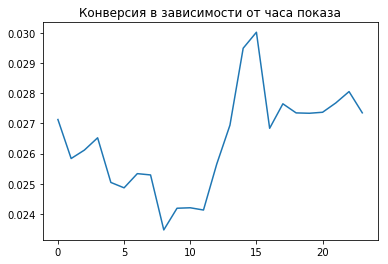


Есть дневная цикличность. Возможно она поможет в построении модели.
    
################################


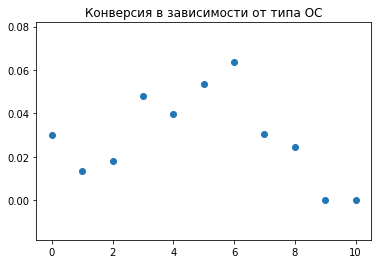


Однозначно стоит использовать данный признак.
    
################################


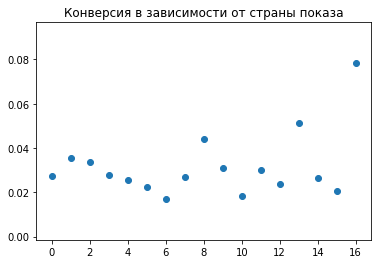


Однозначно стоит использовать данный признак.
    
################################
zone_id

    Краткая информация по признаку "zone_id":
        Количество уникальный значений: 3444
        В 95.0% встречается лишь 160 значений признака
        
banner_id

    Краткая информация по признаку "banner_id":
        Количество уникальный значений: 1633
        В 95.0% встречается лишь 503 значений признака
        
os_id

    Краткая информация по признаку "os_id":
        Количество уникальный значений: 11
        В 95.0% встречается лишь 4 значений признака
        
country_id

    Краткая информация по признаку "country_id":
        Количество уникальный значений: 17
        В 95.0% встречается лишь 11 значений признака
        


In [5]:
analysis(df)

In [6]:
df = df[1:].reset_index(drop=True)

Подготовим признаки для модели

In [7]:
df = decrease_cardinality(df, 'zone_id')
df = decrease_cardinality(df, 'banner_id')

Модель только на OHE признаках

In [8]:
dates = pd.date_range('2021-09-26', '2021-10-02', freq='1d')
indexes = [df[df['date_time'] >= date].index.min() for date in dates]
indexes = tuple(zip(indexes[:-2], indexes[1:-1], indexes[2:]))

train_index_max = df[df['date_time'] < '2021-10-02'].index.max()

x_train, x_test = df[:train_index_max], df[train_index_max:]
y_train, y_test = df.iloc[:train_index_max]['clicks'], df.iloc[train_index_max:]['clicks']

In [9]:
path_to_train_data = './data/train_ffm.txt'
path_to_valid_data = './data/valid1_ffm.txt'
path_to_model = './trained_models/model.out'
path_to_predictions = './output/predictions.txt'

param = {
    'task': 'binary',
    'lr': 0.2,
    'lambda': 0.002,
    'k': 4,
    'epoch': 5,
}

In [10]:
%%time
NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['oaid_hash', 'banner_id']

losses, models = cv(
    x_train,
    path_to_train_data,
    y_train,
    path_to_valid_data,
    indexes,
    NUMERICAL_FEATURES,
    CATEGORICAL_FEATURES,
    param,
    path_to_model,
    path_to_predictions
)

Train size: 3102611
Valid size: 2367304
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.083
Train size: 2367304
Valid size: 2307356
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0898
Train size: 2307356
Valid size: 2420589
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1178
Train size: 2420589
Valid size: 1851190
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1431
Train size: 1851190
Valid size: 1643447
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Don

In [24]:
np.mean(losses), np.std(losses)

(0.11907008848478866, 0.030298784207350344)

In [25]:
%%time
NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['oaid_hash', 'banner_id', 'os_id']

losses, models = cv(
    x_train,
    path_to_train_data,
    y_train,
    path_to_valid_data,
    indexes,
    NUMERICAL_FEATURES,
    CATEGORICAL_FEATURES,
    param,
    path_to_model,
    path_to_predictions
)

Train size: 3102611
Valid size: 2367304
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0824
Train size: 2367304
Valid size: 2307356
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0893
Train size: 2307356
Valid size: 2420589
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1174
Train size: 2420589
Valid size: 1851190
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1422
Train size: 1851190
Valid size: 1643447
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Do

In [26]:
np.mean(losses), np.std(losses)

(0.11771618304562233, 0.029055173992892723)

In [27]:
%%time
NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['oaid_hash', 'banner_id', 'os_id', 'zone_id']

losses, models = cv(
    x_train,
    path_to_train_data,
    y_train,
    path_to_valid_data,
    indexes,
    NUMERICAL_FEATURES,
    CATEGORICAL_FEATURES,
    param,
    path_to_model,
    path_to_predictions
)

Train size: 3102611
Valid size: 2367304
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0826
Train size: 2367304
Valid size: 2307356
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0889
Train size: 2307356
Valid size: 2420589
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1165
Train size: 2420589
Valid size: 1851190
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1387
Train size: 1851190
Valid size: 1643447
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Do

In [28]:
np.mean(losses), np.std(losses)

(0.11620228118420736, 0.027694247367469553)

In [43]:
%%time
NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['oaid_hash', 'banner_id', 'os_id', 'zone_id', 'country_id']

losses, models = cv(
    x_train,
    path_to_train_data,
    y_train,
    path_to_valid_data,
    indexes,
    NUMERICAL_FEATURES,
    CATEGORICAL_FEATURES,
    param,
    path_to_model,
    path_to_predictions
)

Train size: 3102611
Valid size: 2367304
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0845
Train size: 2367304
Valid size: 2307356
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.091
Train size: 2307356
Valid size: 2420589
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1181
Train size: 2420589
Valid size: 1851190
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1421
Train size: 1851190
Valid size: 1643447
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Don

In [44]:
np.mean(losses), np.std(losses)

(0.11884671397172183, 0.028539050098160098)

В предыдущий раз обучал модель с country_id. Теперь данный признак ухудшает качество. Возможно дело в том, что длина эмбединга стала меньше чем кол-во полей. Давайте попробуем их выровнять.

In [45]:
%%time
NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['oaid_hash', 'banner_id', 'os_id', 'zone_id', 'country_id']

param = {
    'task': 'binary',
    'lr': 0.2,
    'lambda': 0.002,
    'k': 5,
    'epoch': 5,
}

losses, models = cv(
    x_train,
    path_to_train_data,
    y_train,
    path_to_valid_data,
    indexes,
    NUMERICAL_FEATURES,
    CATEGORICAL_FEATURES,
    param,
    path_to_model,
    path_to_predictions
)

Train size: 3102611
Valid size: 2367304
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0845
Train size: 2367304
Valid size: 2307356
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.091
Train size: 2307356
Valid size: 2420589
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.118
Train size: 2420589
Valid size: 1851190
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1421
Train size: 1851190
Valid size: 1643447
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done

In [46]:
np.mean(losses), np.std(losses)

(0.11883009436607869, 0.028518086489418646)

Ничего не вышло. Придется выкинуть country_id.

Подберем параметры для модели на фиксированном наборе признаков.

In [17]:
%%time
NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['oaid_hash', 'banner_id', 'os_id', 'zone_id']

param = {
    'task': 'binary',
    'lr': 0.2,
    'lambda': 0.002,
    'k': 6,
    'epoch': 5,
}

losses, models = cv(
    x_train,
    path_to_train_data,
    y_train,
    path_to_valid_data,
    indexes,
    NUMERICAL_FEATURES,
    CATEGORICAL_FEATURES,
    param,
    path_to_model,
    path_to_predictions
)

Train size: 3102611
Valid size: 2367304
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0837
Train size: 2367304
Valid size: 2307356
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.09
Train size: 2307356
Valid size: 2420589
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1172
Train size: 2420589
Valid size: 1851190
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.14
Train size: 1851190
Valid size: 1643447
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done w

In [20]:
np.mean(losses), np.std(losses)

(0.11741377182551709, 0.02794670274576291)

In [21]:
%%time
NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['oaid_hash', 'banner_id', 'os_id', 'zone_id']

param = {
    'task': 'binary',
    'lr': 0.2,
    'lambda': 0.002,
    'k': 3,
    'epoch': 5,
}

losses, models = cv(
    x_train,
    path_to_train_data,
    y_train,
    path_to_valid_data,
    indexes,
    NUMERICAL_FEATURES,
    CATEGORICAL_FEATURES,
    param,
    path_to_model,
    path_to_predictions
)

Train size: 3102611
Valid size: 2367304
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0837
Train size: 2367304
Valid size: 2307356
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0901
Train size: 2307356
Valid size: 2420589
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1173
Train size: 2420589
Valid size: 1851190
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1399
Train size: 1851190
Valid size: 1643447
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Do

In [22]:
np.mean(losses), np.std(losses)

(0.11743593134912363, 0.02791670571723133)

Подбор размера скрытого вектора и кол-ва эпох особых результатов не дал.
Обучим модель с базовыми пааметрами еще раз и предскажем на тесте.

In [11]:
%%time
NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['oaid_hash', 'banner_id', 'os_id', 'zone_id']

param = {
    'task': 'binary',
    'lr': 0.2,
    'lambda': 0.002,
    'k': 4,
    'epoch': 15,
    'metric': 'auc',
}

losses, models = cv(
    x_train,
    path_to_train_data,
    y_train,
    path_to_valid_data,
    indexes,
    NUMERICAL_FEATURES,
    CATEGORICAL_FEATURES,
    param,
    path_to_model,
    path_to_predictions
)

Train size: 3102611
Valid size: 2367304
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0819
Train size: 2367304
Valid size: 2307356
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0883
Train size: 2307356
Valid size: 2420589
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1161
Train size: 2420589
Valid size: 1851190
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1387
Train size: 1851190
Valid size: 1643447
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Do

In [13]:
%%time
NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['oaid_hash', 'banner_id', 'os_id', 'zone_id']

param = {
    'task': 'binary',
    'lr': 0.2,
    'lambda': 0.002,
    'k': 3,
    'epoch': 30,
    'metric': 'auc',
}

losses, models = cv(
    x_train,
    path_to_train_data,
    y_train,
    path_to_valid_data,
    indexes,
    NUMERICAL_FEATURES,
    CATEGORICAL_FEATURES,
    param,
    path_to_model,
    path_to_predictions
)

Train size: 3102611
Valid size: 2367304
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0812
Train size: 2367304
Valid size: 2307356
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.0882
Train size: 2307356
Valid size: 2420589
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1171
Train size: 2420589
Valid size: 1851190
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Done writing valid strings
Learning
Logloss: 0.1386
Train size: 1851190
Valid size: 1643447
Converting data to ffm_lib file format
Done making train strings
Done making valid strings
Done writing train strings
Do

In [16]:
path_to_test_data = './data/test_ffm.txt'

NUMERICAL_FEATURES = ['campaign_clicks']
CATEGORICAL_FEATURES = ['oaid_hash', 'banner_id', 'os_id', 'zone_id']

print('Converting data to ffm_lib file format')
x_test, _ = encode_cat_features(x_test.copy(), x_test.copy(), CATEGORICAL_FEATURES)

test_strings = create_string(x_test, NUMERICAL_FEATURES, CATEGORICAL_FEATURES)
print('Done making test strings')

with open(path_to_test_data, 'w') as f:
    for row in test_strings:
        f.write(row)  
print('Done writing test strings') 

Converting data to ffm_lib file format
Done making test strings
Done writing test strings


In [17]:
def predict(model):
    model.setTest(path_to_test_data)
    model.setSigmoid()
    model.predict(path_to_model, path_to_predictions)

    with open(path_to_predictions, 'r') as f:
        data = f.read().split('\n')[:-1]

    return log_loss(y_test, pd.Series(data).astype('float'))   

In [18]:
predict(models[-1])

0.14643649390012808

В лаобраторной №1 получилось вот так

In [26]:
cv_result = pd.DataFrame(losses_total, index=coeffs)
best_c = cv_result.mean(axis=1).sort_values().index[0]
best_arg = (coeffs == best_c).argmax()

predict = [model.predict_proba(x_test)[:, 1] for model in models_total[best_arg]]

print(f'Лучший параметр С: {best_c}')
print(f'Logloss рандомной модели: {log_loss(y_test, [y_test.mean()]*y_test.shape[0])}')
print(f'Logloss на модели за предыдущий день: {log_loss(y_test, predict[-1])}')
print(f'Logloss на усредненной модели: {log_loss(y_test, np.mean(predict, axis=0))}')

Лучший параметр С: 0.1668100537200059
Logloss рандомной модели: 0.15303284409655607
Logloss на модели за предыдущий день: 0.1333048943374224
Logloss на усредненной модели: 0.13713972438217994


Разбираться с ffm намного тяжелее чем с LR. В частности за счет скорости обучения и необходимости заранее формировать файлы для обучения и предсказаний. В целом в статьях показано, что FFM хорошо работает на больших и разреженных данных. В данном случае не удалось побить результыт с первой работы. Причин несколько: 1) первая работа сделано относительно хорошо 2) не совсем очевидно нужно ли генерировать взаимодействия признаков как фичи. Есть ощущение, что ffm сам за нас это делает; 3) плохо подбирал гиперпараметры, но не думаю, что ими можно объяснить такую разницу в метриках; 4) почему-то country_id ухудшил качество модели